In [1]:
import pandas as pnd
import numpy as np
from sklearn import preprocessing
from sklearn import neighbors, datasets
from sklearn import cross_validation
from sklearn.linear_model import SGDClassifier
from sklearn import svm
import operator

from sklearn.cross_validation import KFold

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn import tree
import seaborn as sns

from IPython.display import Image

%matplotlib inline

C:\Users\Rhea\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# function for confusion matrix building
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def visualize_tree(tr, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        tree.export_graphviz(tr, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]

In [7]:
# add the rows names
header_row = ['age','sex','chest_pain','blood pressure','serum_cholestoral','fasting_blood_sugar',\
               'electrocardiographic','max_heart_rate','induced_angina','ST_depression','slope','vessels','thal','diagnosis']

# read csv file with Cleveland heart diseases data
heart = pnd.read_csv('C:/Users/Rhea/Documents/Bayesian Modeling/Datasets/heart_disease/processed_cleveland_data.csv', names=header_row)
heart[:5]

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,thal,diagnosis
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [9]:
# get number of people with symptom X_k
names_descr = dict()
categorical_columns = ["sex", "chest_pain", "fasting_blood_sugar", "electrocardiographic", "induced_angina", "slope", "vessels", \
                       "thal", "diagnosis"]
for c in categorical_columns:
    print(heart.groupby([c])["age"].count())

sex
0.0     97
1.0    206
Name: age, dtype: int64
chest_pain
1.0     23
2.0     50
3.0     86
4.0    144
Name: age, dtype: int64
fasting_blood_sugar
0.0    258
1.0     45
Name: age, dtype: int64
electrocardiographic
0.0    151
1.0      4
2.0    148
Name: age, dtype: int64
induced_angina
0.0    204
1.0     99
Name: age, dtype: int64
slope
1.0    142
2.0    140
3.0     21
Name: age, dtype: int64
vessels
0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: age, dtype: int64
thal
3.0    166
6.0     18
7.0    117
?        2
Name: age, dtype: int64
diagnosis
0    164
1     55
2     36
3     35
4     13
Name: age, dtype: int64


In [10]:
# change unrecognized value '?' into mean value through the column
for c in heart.columns[:-1]:
    heart[c] = heart[c].apply(lambda x: heart[heart[c]!='?'][c].astype(float).mean() if x == "?" else x)
    heart[c] = heart[c].astype(float)

In [11]:
# print the types of heart disease
set(heart.loc[:, "diagnosis"].values)

{0, 1, 2, 3, 4}

In [20]:
heart.loc[:, "diag_int"] = heart.loc[:, "diagnosis"].apply(lambda x: 1 if x >= 1 else 0)

In [22]:
# create the normalizer and fit it 
preprocessing.Normalizer().fit_transform(heart)

array([[ 0.19741527,  0.00313358,  0.00313358, ...,  0.01880145,
         0.        ,  0.        ],
       [ 0.19057465,  0.0028444 ,  0.01137759, ...,  0.00853319,
         0.0056888 ,  0.0028444 ],
       [ 0.22578159,  0.00336987,  0.0134795 , ...,  0.02358912,
         0.00336987,  0.00336987],
       ..., 
       [ 0.25334975,  0.00444473,  0.01777893, ...,  0.03111313,
         0.0133342 ,  0.00444473],
       [ 0.17495449,  0.        ,  0.00613875, ...,  0.00920813,
         0.00306938,  0.00306938],
       [ 0.13346695,  0.00351229,  0.01053686, ...,  0.01053686,
         0.        ,  0.        ]])

In [24]:
# split dataset into train and test
heart_train, heart_test, goal_train, goal_test = cross_validation.train_test_split(heart.loc[:,'age':'thal'], \
                                                 heart.loc[:,'diag_int'], test_size=0.33, random_state=0)

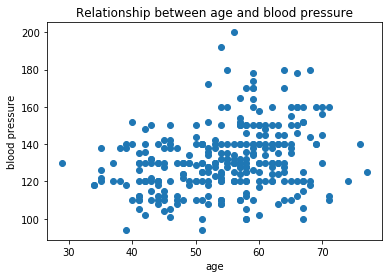

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel("age")
plt.ylabel("blood pressure")

# define title
plt.title("Relationship between age and blood pressure")

# plot
plt.scatter(heart['age'], heart['blood pressure'])
plt.show()


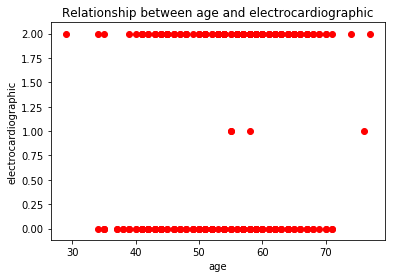

In [26]:
plt.xlabel("age")
plt.ylabel("electrocardiographic")

# define title
plt.title("Relationship between age and electrocardiographic")

# plot
plt.scatter(heart['age'], heart['electrocardiographic'], color = 'red')
plt.show()

In [ ]:
# calculate the correlation between features

corr = heart.corr()
heart.corr()

In [32]:
# develop the model with the best parameters

lss_best = SGDClassifier(alpha=0.05, fit_intercept=True, loss='log', n_iter=1000,
penalty='l1')
lss_best.fit(heart_train, goal_train)
print("Linear regression SGD Test score:")
print(lss_best.score(heart_test, goal_test))

Linear regression SGD Test score:
0.81


C:\Users\Rhea\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Confusion matrix, without normalization
[[45  4]
 [15 36]]


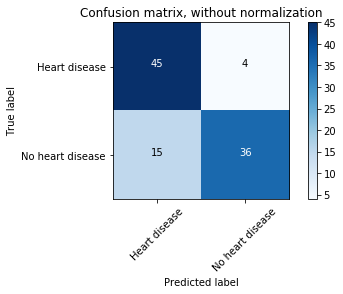

In [33]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(goal_test, lss_best.predict(heart_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Heart disease", "No heart disease"],
                      title='Confusion matrix, without normalization')
plt.show()

In [34]:
#get the performance metrics
scores = ['accuracy', 'f1', 'precision', 'recall']

metrics = {score: cross_validation.cross_val_score(lss_best,heart_test, goal_test, scoring=score).mean() for score in scores}

metrics

C:\Users\Rhea\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\Rhea\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\Rhea\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\Rhea\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Users\Rhea\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gr

{'accuracy': 0.76024955436720154,
 'f1': 0.74357864357864367,
 'precision': 0.85303544494720962,
 'recall': 0.62745098039215685}

In [36]:

# predict heart disease for test dataset
y_pred_proba = lss_best.predict_proba(heart_test)
y_pred_proba = [x[1] for x in y_pred_proba]


1.10778291564e-70
1.0
0.00346478394387
1.09943298865e-41
2.5844229684e-33
1.0
1.0
0.999999999992
1.0
8.36862512897e-38


In [37]:

# predict heart disease for test dataset
y_pred = lss_best.predict(heart_test)
y_pred[:25]

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0], dtype=int64)

In [38]:
test_df = pnd.DataFrame(heart_test, columns = header_row[:-1])

test_df.loc[:, "Disease_probability"] = [x[1] for x in lss_best.predict_proba(heart_test)]
test_df.to_excel("disease_probability.xlsx", index = False)
test_df[:5]

,age,sex,chest_pain,blood pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,vessels,thal,Disease_probability
225,34.0,0.0,2.0,118.0,210.0,0.0,0.0,192.0,0.0,0.7,1.0,0.0,3.0,1.107783e-70
152,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1.000000e+00
228,54.0,1.0,4.0,110.0,206.0,0.0,2.0,108.0,1.0,0.0,2.0,1.0,3.0,3.464784e-03
201,64.0,0.0,4.0,180.0,325.0,0.0,0.0,154.0,1.0,0.0,1.0,0.0,3.0,1.099433e-41
52,44.0,1.0,4.0,112.0,290.0,0.0,2.0,153.0,0.0,0.0,1.0,1.0,3.0,2.584423e-33


In [41]:

# print weights for each X_k from the built  LSS model
w = lss_best.coef_[0]
a = -w[0] / w[1]
print ("Weight Coefficients")
coeff_df = pnd.DataFrame(columns = ['X_k', 'coeff'])
for c in range(len(heart.loc[:,'age':'thal'].columns)):
    coeff_df.loc[len(coeff_df)] = [heart.loc[:,'age':'thal'].columns[c], w[c]]
    
coeff_df

Weight Coefficients


C:\Users\Rhea\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


,X_k,coeff
0,age,0.000000
1,sex,0.000000
2,chest_pain,11.644995
3,blood pressure,-0.137679
4,serum_cholestoral,0.049670
5,fasting_blood_sugar,0.000000
6,electrocardiographic,0.000000
7,max_heart_rate,-1.477421
8,induced_angina,2.514117
9,ST_depression,17.649453
